In [1]:
# import packages
import numpy as np
import math
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

# from orbvel import f
# from rungekutte import rk4
# from config import *

## Two-body dynamics: setting up Runge-Kutte method

In [2]:
def f(rs, **kwargs):
    """
    Evaluate the second derivative of the position vector in 2D.
    
    Inputs:  array with x-, y- components of the position vector
    Returns: array of x-,y- components of acceleration 
             evaluated at these points
    """
        
    # position of mass1, mass2    
    x1, y1 = rs[0], rs[1]  
    x2, y2 = rs[2], rs[3] 
    r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # x, y components of Acceleration a(t) = x''(t), which is also v'(t)
    ax1 = G*m2*(x2 - x1)/r**3    
    ay1 = G*m2*(y2 - y1)/r**3    
    ax2 = G*m1*(x1 - x2)/r**3    
    ay2 = G*m1*(y1 - y2)/r**3    
    
    return np.array([ax1, ay1, ax2, ay2], float)


In [71]:
def get_f(r, f):
    """
    Calculate updated x, y, vx, vy for each particle using a function 
        f(x,y,t) = v'(t)
    
    Inputs:
        r, 1-D array [x1,y1,x2,y2,vx1, vy1, vx2, vy2]
        
    Returns:
        fxy, 1-D array v(t), f(x,y,t)
        
    """
    
    x1, y1 = r[0], r[1]
    vx1, vy1 = r[4], r[5]
    x2, y2 = r[2], r[3]
    vx2, vy2 = r[6], r[7]
    
    fxy = np.array([vx1, vy1, vx2, vy2])
    fv = f(np.array([x1, y1, x2, y2]))
    
    return np.array(np.concatenate([fxy, fv]))
    

In [85]:
def rk4(t0, tmax, r0, v0, f, h, err_tol, r_ref):
    """
    Calculate orbit of a body about center of mass using 4th-order Runge-Kutte
    method.
    
    Inputs:
      t0, tmax: start, end time of simulation, Myr
      r0: initial position of second body, kpc
      v0: initial velocity (in +y direction) of second body, kpc/Myr
      f: function for getting vx', vy'
      h: time interval
      err_tol: amount of allowed deviation from r_ref
      r_ref: expected value for r2
    
    Returns:
      R: 2-D array of x1,y1,x2,y2 coordinates at each step
      err: relative error of path compared to circle/ellipse/etc.
      
    """
    
    # Initialize arrays for time, position vector, & velocity vector
    ti = t0
    t = np.array(ti)
    # mass 1 starts at point of furthest separation
    x1 = r0  # kpc
    y1 = 0   # kpc
    vx1 = 0
    vy1 = v0
    # use center of mass m1x1 = m2x2 to get position, vel of mass 2
    x2 = -(m1/m2)*r0
    y2 = 0
    vx2 = 0
    vy2 = -(m1/m2)*v0
     
    print(f"initial R: {[x1, y1, x2, y2]}, f(R) = {f(np.array([x1, y1, x2, y2]))}")
    # initialize arrays of positions at each step
    ri = np.array([x1, y1, x2, y2], float)
    
    # initialize arrays of velocities at each step
    vinit = np.array([vx1, vy1, vx2, vy2], float)
    vi = vinit
    v_ = np.array([vi]) # Initial vx, vy
    
    # initialize position-velocity mega-vector
    r = np.concatenate([ri,vi])
    R = np.array([r])
    
    
    debug = False
    
    # Initialize steps for error check for circular orbit
    r_check = np.sqrt(r[0]**2 + r[1]**2)  # current radius, r
    rel_err = (r_ref - r_check)/r_ref
    print(f"init err: {rel_err}")
    err = np.array([rel_err])
    
    # solve eqns of motion using R-K method
    while np.abs(rel_err) < err_tol:
        # break if t = tmax
        if ti > tmax:
            if debug: print(f"Time: {ti} > {tmax}")
            break
        else:
            # calculate r(t), r'(t)
            
            # compute k1, k2, k3, k4 for r
            k1  = h*get_f(r, f)
            k2 = h*get_f(r + k1*0.5, f) 
            k3 = h*get_f(r + k2*0.5, f) 
            k4 = h*get_f(r + k3, f)  

            # update ti, Ri
            ti += h
            r += (1/6)*(k1 + 2*k2 + 2*k3 + k4)

            # calculate new rel error
            r_check = np.sqrt(r[0]**2 + r[1]**2)  # current radius, r
            rel_err = (r_ref - r_check)/r_ref
            if debug: print(f"{ti} {r_check} {rel_err}")

            # save new ri to r
            t = np.append(t, ti)
            R = np.append(R, np.array([r]), axis=0)
            err = np.append(err, rel_err) # relative error
            
    # components of cartesian coords
    # R: [x1, x2, y1, y2]
    X = R[:,[0,2]]  # x1, x2
    Y = R[:,[1,3]]  # y1, y2
    return t, X, Y, err # v_ , err


In [96]:
# runtime initial conditions
t0, tmax = 0, 5000
h = 1 # 1e-3 Myr


# UNITS: kpc, Msun, Myr
# constants
G = (const.G).to(u.kpc**3 * u.Msun**-1 * u.Myr**-2).value # kpc^3/Msun/Myr

# orbit parameters
m1 = 1e12 # Msun
m2 = 1e12 # Msun
M = m1 + m2

# can get a = (G*M*T**2/(4*np.pi**2))**(1/3)
a = 100    # semi-major axis (kpc, Kepler's Law)
ecc = 1e-12 # 0.5
p = a*(1 - ecc**2)   # semi-latus rectum (kpc)

# starting position of second galaxy 
r0 = (m2/M)*a   #for circular orbit
    
# starting velocity of the second galaxy
v0 = np.sqrt(G*m2/a)*np.sqrt((m2*(1-ecc**2))/M)

# make sure r is close to analytic value over time
err_tol = 1e-5  # allowable error 

In [97]:
t, X, Y, err = rk4(t0, tmax, r0, v0, f, h, err_tol, r0)

initial R: [50.0, 0, -50.0, 0], f(R) = [-0.00044985  0.          0.00044985  0.        ]
init err: 0.0


cumulative error over 5001 Myr: 6.2861e-09 kpc


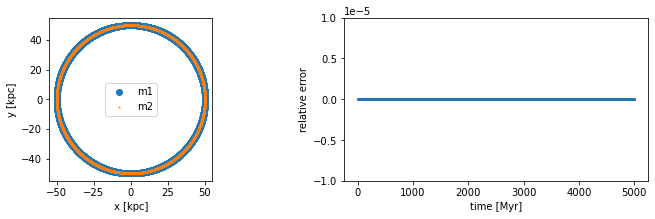

In [98]:
fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(121, aspect='equal')
ax1.scatter(X[:,0], Y[:,0], label="m1")
ax1.scatter(X[:,1], Y[:,1], s=1, label="m2")
ax1.set_xlabel("x [kpc]"), ax1.set_ylabel("y [kpc]")
plt.legend()

ax2 = fig.add_subplot(122,aspect='auto')
ax2.scatter(t, err, s=1)
ax2.set_ylim(err_tol*np.array([-1,1]))
ax2.set_xlabel("time [Myr]"), ax2.set_ylabel("relative error")
print(f"cumulative error over {t[-1]} Myr: {sum(err):.6} kpc")